# The Battle of Mumbai Restaurants

###  Comparing and Exploring different restaurant venues in Mumbai, India

### Table of Contents

* [Introduction](#introduction)
* [Data Collection from APIs](#data_collection)
* [Data Cleaning](#data_cleaning)
* [Methodolgy](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

### Introduction <a name="introduction"></a>

The aim of the project is to identify restaurants in Mumbai, India based on their rating and average prices. In this notebook, we will identify various restaurants in the city of **Mumbai, India**, using **Foursquare API** and **Zomato API**, to help visitors select the restaurants that suit them the best.

Whenever a user is visiting a city, they start looking for places to visit and restaurants to eat at during their stay. They primarily look for restaurants based on their ratings and average price, such that the venue fits in their budget.

Here, we'll **identify restaurants that are fit for various individuals** based on the information collected from the Foursquare API, Zomato API, and Data Science. Once we have the plot with the venues, any company can launch an application using the same data, and suggest to users such information.

### Data Collection from APIs <a name="data_collection"></a>

To begin with, we will take a look at **Mumbai on the Map** using the `folium` library.

We will also fetch the data from **Foursquare API** and **Zomato API**.
* **Foursquare API:** We will use the Foursquare API to fetch venues in Mumbai starting from the middle upto 4 Kilometers in each direction.
* **Zomato API:** The Zomato API provides information about various venues including the complete address, user ratings, price for two people, price range and a lot more.

### Mumbai

**Mumbai**(previously known as **Bombay**), is the capital city of the Indian state of Maharashtra. According to the United Nations, as of 2018, Mumbai is the second-most populous city in the country after Delhi and the seventh-most populous city in the world with a population of roughly 20 million. It is composed of seven islands, spread across a total area of about 600 sq Km. There are numerous venues (especially restaurants, hotels, and cafes) that can be explored.

In [2]:
# Importing Libraries

!pip install folium
import folium

!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

from pandas import json_normalize
import requests
from bs4 import BeautifulSoup 

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', None)

print('Libraries imported.')

Libraries imported.


**We will use the `geopy` library to extract the latitude and longitude values of Mumbai.**

In [3]:
address = 'Mumbai, India'

geolocator = Nominatim(user_agent='mumbai_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Mumbai are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Mumbai are 19.0759899, 72.8773928.


Let's use the `folium` library to create a **complete map zoomed on Mumbai**. We'll also plot a marker on the coordinates we just identified above. This would give us a relatively good look at the center point we will be considering. 

In [4]:
mumbai_map = folium.Map(location = [latitude, longitude], zoom_start = 12)
folium.Marker([latitude, longitude]).add_to(mumbai_map)

mumbai_map

### Foursquare API

We begin by fetching a total of all venues in **Mumbai** upto a range of 4 Kilometers using the Foursquare API. The Foursquare API has the `explore` API which allows us to find venue recommendations within a given radius from the given coordinates. We will use this API to find all the venues we need.

In [5]:
CLIENT_ID =      # Hidden, sensitive data #
CLIENT_SECRET =  # Hidden, sensitive data #
RADIUS = 4000        # 4 Km
LIMIT = 100          # No. of venues
VERSION = '20210818' # Current date

We define the `get_category_type` method to get the correct category for each venue.

In [6]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

We'll call the API over and over till we get all venues from the API within the given distance. The maximum venues this API can fetch is 100, so we will fetch all venues by iteratively calling this API and increasing the offset each time.

* Foursquare API requires client_id, and client_secret to function which can be accessed after creating a developer account. 
* We will set the radius as 4 Kilometers. 
* The version is a required parameter which defines the date on which we are browsing so that it retrieves the latest data.

In [7]:
offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(CLIENT_ID, 
                                                                        CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        latitude, 
                                                                        longitude, 
                                                                        RADIUS,
                                                                        LIMIT,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

Total 100 venues fetched within a total radius of 4.0 Km
Total 87 venues fetched within a total radius of 4.0 Km

Total 187 venues fetched


In [8]:
foursquare_venues.head()

,name,categories,lat,lng
0,Hitchki,Bar,19.069730,72.869761
1,Sofitel Mumbai BKC,Hotel,19.067448,72.869006
2,The Bar Stock Exchange,Bar,19.071166,72.876359
3,Smoke House Deli (BKC),Deli / Bodega,19.068783,72.869665
4,Trident,Hotel,19.066808,72.867468


### Zomato API

The Zomato API allows using its search API to search for any given venue based on certain search filters such as query, latitude, longitude and more. Zomato also requires a Zomato user key which can be accessed with a developer account.

We'll use the `name`, `lat`, and `lng` values of various venues fetched from Foursquare API to use the search API and get more information regarding each venue.

* The query will be the name of the venue.
* The start defines from what offset we want to start, so we'll keep it at 0.
* The count defines the number of restaurants we want to fetch. As we have the exact location coordinates, we'll fetch only one.
* We will supply the latitude and longitude values.
* We will set the sorting criteria as `real_distance` so each time we get the venue we're searching based on location coordinates.

In [9]:
headers = {'user-key': # Hidden, sensitive data #}
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    try:
        result = requests.get(url, headers = headers).json()
    except:
        print("There was an error...")
    try:
        
        if (len(result['restaurants']) > 0):
            venue.append(result['restaurants'][0]['restaurant']['name'])
            venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
            venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
            venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
            venue.append(result['restaurants'][0]['restaurant']['price_range'])
            venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
            venue.append(result['restaurants'][0]['restaurant']['location']['address'])
            venues_information.append(venue)
        else:
            venues_information.append(np.zeros(6))
    except:
        pass
        
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

In [10]:
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

### Data Cleaning <a name="data_cleaning"></a>

The data from multiple resources might not always align. Thus, it is **important to combine the data retrieved from multiple resources properly**.

We'll first plot the two data points on the map. We'll then try to combine data points that have their latitude and longitude values very close to one another. From the remaining selected venues, we will inspect the venues to ensure that any remaining mismatched venues are also removed from the final dataset of venues before we begin any analysis.

We will first plot the Foursquare data on the map.

In [11]:
mumbai_map = folium.Map(location = [latitude, longitude], zoom_start = 13)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(mumbai_map)  

mumbai_map

From the map, we can infer that there are clusters of venues around **Bandra Kurla Complex**, **Airport Area**, **Ghatkopar East** and **Chembur West**. We can also plot the category count and see the major type of venues that exist.

We will also plot the Zomato data on the map.

In [12]:
mumbai_map = folium.Map(location = [latitude, longitude], zoom_start = 13)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'], zomato_venues['longitude']):
    UPDATED_LG = float(longitude)
    UPDATED_LT = float(latitude)
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [UPDATED_LT, UPDATED_LG],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(mumbai_map)  

mumbai_map

**Now we will plot both Zomato and FourSquare data in a single map**

In [13]:
mumbai_map = folium.Map(location = [latitude, longitude], zoom_start = 13)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'], zomato_venues['longitude']):
    UPDATED_LG = float(longitude)
    UPDATED_LT = float(latitude)
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [UPDATED_LT, UPDATED_LG],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(mumbai_map)  
    
for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(mumbai_map)  

mumbai_map

We can see that there are many venues identified by both Foursquare and Zomato. There is a lot of overlapping between the two near **Bandra Kurla Complex**, **Airport Area**, **Ghatkopar East** and **Chembur West**. However, there are many areas where the data does not match - like the red dots in the left and upper left on the above map.

To combine the two datasets, we will have to check that the latitude and longitude values of each corresponding venue match. Thus, we will round both the latitude and longitude values upto 4 decimal places. Then, we will calculate the difference between the corresponding latitude and longitude values and see if the difference is less than 0.0004, which should ideally mean that the two locations are same.

In [14]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [15]:
foursquare_venues.head()

,name,categories,lat,lng
0,Hitchki,Bar,19.0697,72.8698
1,Sofitel Mumbai BKC,Hotel,19.0674,72.8690
2,The Bar Stock Exchange,Bar,19.0712,72.8764
3,Smoke House Deli (BKC),Deli / Bodega,19.0688,72.8697
4,Trident,Hotel,19.0668,72.8675


In [16]:
zomato_venues.head()

,venue,latitude,longitude,price_for_two,price_range,rating,address
0,Hitchki,19.0696,72.8699,1700.0,3.0,4.2,"002, First International Financial Centre, G B..."
1,Jyran - Sofitel,19.0676,72.8692,3300.0,4.0,4.5,"Sofitel Hotel, C 57, Bandra Kurla Complex, Mumbai"
2,Rajkamal Restaurant,19.0698,72.8791,900.0,2.0,0,"Opposite Municipality, L Ward, Kurla, Mumbai"
3,Goodness To Go By Smoke House Deli,19.0689,72.8696,800.0,2.0,3.9,"3A, Ground Floor, First International Financia..."
4,O22 - Trident,19.0671,72.8675,4000.0,4.0,4.2,"Trident Hotel, C 56, G Block, Bandra Kurla Com..."


In [17]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [39]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Hitchki,Bar,19.0697,72.8698,Hitchki,19.0696,72.8699,1700.0,3.0,4.2,"002, First International Financial Centre, G B...",-0.0001,0.0001
1,Sofitel Mumbai BKC,Hotel,19.0674,72.8690,Jyran - Sofitel,19.0676,72.8692,3300.0,4.0,4.5,"Sofitel Hotel, C 57, Bandra Kurla Complex, Mumbai",0.0002,0.0002
2,Smoke House Deli (BKC),Deli / Bodega,19.0688,72.8697,Goodness To Go By Smoke House Deli,19.0689,72.8696,800.0,2.0,3.9,"3A, Ground Floor, First International Financia...",0.0001,-0.0001
3,Trident,Hotel,19.0668,72.8675,O22 - Trident,19.0671,72.8675,4000.0,4.0,4.2,"Trident Hotel, C 56, G Block, Bandra Kurla Com...",0.0003,0.0000
4,Masala Library,Indian Restaurant,19.0689,72.8697,Masala Library,19.0689,72.8697,3500.0,4.0,4.7,"Ground Floor, 1st International Financial Cent...",0.0000,0.0000
5,Natural's Ice Cream,Ice Cream Shop,19.0776,72.8630,Natural Ice Cream,19.0776,72.8628,300.0,1.0,4.2,"3, Gokul Harmony, Kalina Market, Sunder Nagar,...",0.0000,-0.0002
6,Starbucks Coffee Capital,Coffee Shop,19.0635,72.8616,Paninaro,19.0635,72.8615,600.0,2.0,3.6,"The Capital, Bandra Kurla Complex, Mumbai",0.0000,-0.0001
7,Naaz Hotel,Indian Restaurant,19.0848,72.8892,Naaz Hotel,19.0848,72.8891,700.0,2.0,4.2,"Opposite Phoenix Market City, Kantharia Mahal,...",0.0000,-0.0001
8,Yauatcha,Dim Sum Restaurant,19.0614,72.8627,Yauatcha,19.0610,72.8625,2800.0,4.0,4.6,"Raheja Tower, Bandra Kurla Complex, Mumbai",-0.0004,-0.0002
9,Theobrama,Dessert Shop,19.0635,72.8617,Theobroma,19.0636,72.8618,500.0,2.0,4.3,"The Capital, Ground Floor, Bandra Kurla Comple...",0.0001,0.0001


If we take a look at the names of venues from both APIs, some names seem to be a complete mismatch. We can divide the rows into two catagory -

**Category 1:** There are venues that have specific restaurants/cafes inside them as provided by Zomato API (**Masala Mantar**                 in Phoenix Marketcity Mall - index 11).

**Category 2:** Two locations are so close by that they have practically same latitude and longitude values (**Cafe Zebro** and                 **Barista** - index 68, **Paninaro** and **Starbucks** - index 6).

The venues which belong to **category 1** are alright to keep. However, the venues that fall under **category 2** should be removed. This is because, we will later plot the catagory of the restaurants against their count. However, the catagory of the restaurant has been obtained from Foursquare, not Zomato. Hence, if we drop the Foursquare venues, we will have to drop their respective catagory as well. Accordingly, we will have to drop the Zomato specific data for that row, as a restaurant without its catagory will not be very useful to us.

In [40]:
index_to_drop = [6, 11, 12, 15, 23, 26, 27, 28, 29, 32, 34, 35, 36, 37, 39, 44, 45, 49, 54, 59, 64, 66, 67, 74, 76, 79, 82]
selected_venues = selected_venues.drop(index_to_drop).reset_index(drop = True)

We will now keep the venue name from **Zomato API**. We will also create a new column `average_price`, which will contain the average price per person, by dividing the column `price_for_two` by 2 and removing this column from the dataset, along with other unnecessary columns.

In [41]:
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

**We will now rearrange positions of and rename some columns, to make the data more presentable**

In [42]:
selected_venues = selected_venues.loc[:, ['venue', 'categories', 'rating', 'average_price', 'price_range', 'latitude', 'longitude', 'address']]
selected_venues.columns = ["Venue", "Category", "Rating", "Avg. Price", 'Price Range', "Latitude", "Longitude", 'Address']

Let's take a look at the final dataset that is left with us.

In [43]:
selected_venues

,Venue,Category,Rating,Avg. Price,Price Range,Latitude,Longitude,Address
0,Hitchki,Bar,4.2,850.0,3.0,19.0696,72.8699,"002, First International Financial Centre, G B..."
1,Jyran - Sofitel,Hotel,4.5,1650.0,4.0,19.0676,72.8692,"Sofitel Hotel, C 57, Bandra Kurla Complex, Mumbai"
2,Goodness To Go By Smoke House Deli,Deli / Bodega,3.9,400.0,2.0,19.0689,72.8696,"3A, Ground Floor, First International Financia..."
3,O22 - Trident,Hotel,4.2,2000.0,4.0,19.0671,72.8675,"Trident Hotel, C 56, G Block, Bandra Kurla Com..."
4,Masala Library,Indian Restaurant,4.7,1750.0,4.0,19.0689,72.8697,"Ground Floor, 1st International Financial Cent..."
5,Natural Ice Cream,Ice Cream Shop,4.2,150.0,1.0,19.0776,72.8628,"3, Gokul Harmony, Kalina Market, Sunder Nagar,..."
6,Naaz Hotel,Indian Restaurant,4.2,350.0,2.0,19.0848,72.8891,"Opposite Phoenix Market City, Kantharia Mahal,..."
7,Yauatcha,Dim Sum Restaurant,4.6,1400.0,4.0,19.0610,72.8625,"Raheja Tower, Bandra Kurla Complex, Mumbai"
8,Theobroma,Dessert Shop,4.3,250.0,2.0,19.0636,72.8618,"The Capital, Ground Floor, Bandra Kurla Comple..."
9,Delhi Zaika,Indian Restaurant,3.8,350.0,2.0,19.0772,72.8783,"5/6, LBS Marg, Near Kamran Kalpana Theater, Ku..."


Lastly, we will drop the restaurant venues which have `0.0` rating, as it means it has not been rated yet.

In [44]:
selected_venues = selected_venues[selected_venues['Rating'] != 0.0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 58


### Methodology <a name="methodology"></a>

This project aims at identifying the venues in Mumbai based on their rating and average costs. This would enable any visitor to identify the venues he/she wants to visit based on their rating and cost preference.

As a first step, we retrieved the **data from two APIs (Foursquare and Zomato)**. We extract venue information from the center of Mumbai, upto a distance of 4 Km. The latitude and longitude values are then used to fetch venue rating and price from Zomato.

Secondly, we then **explored the data** retrieved from the two APIs on the map and identified the top category types. The **data from the two sources is carefully combined** based on the name, latitude and longitude values from the two sources. The final dataset would include the rating and price values for each venue.

Next, we'll **analyse the data** that we created based on the ratings and price of each venue. We'll **identify places where many venues are located** so that any visitor can go to one place and enjoy the option to choose amongst many venue options. We'll also explore **areas that are high rated and those that are low rated** while also plotting the **map of high and low priced venues**. Lastly, we'll **cluster the venues** based on the available information of each venue. We will achieve this with the help of **K-means Clustering algorithm**. This will allow us to clearly identify which venues can be recommended and with what characteristics.

Finally, we'll discuss and conclude which venues to be explored based on visitor requirement of rating and cost.

### Analysis <a name="analysis"></a>

The complete dataset is now in its final form. 

We will **inspect these venues based on their rating**. The rating of a venue are based on user reviews and belongs to a range from 1 to 5. We'll also **analyse the venues based on their price per person as well as the price range**. 

### Categories

We have various types of restaurant venues in the final dataset. We will take a look at the venues and check which are the majority venue categories in the list.

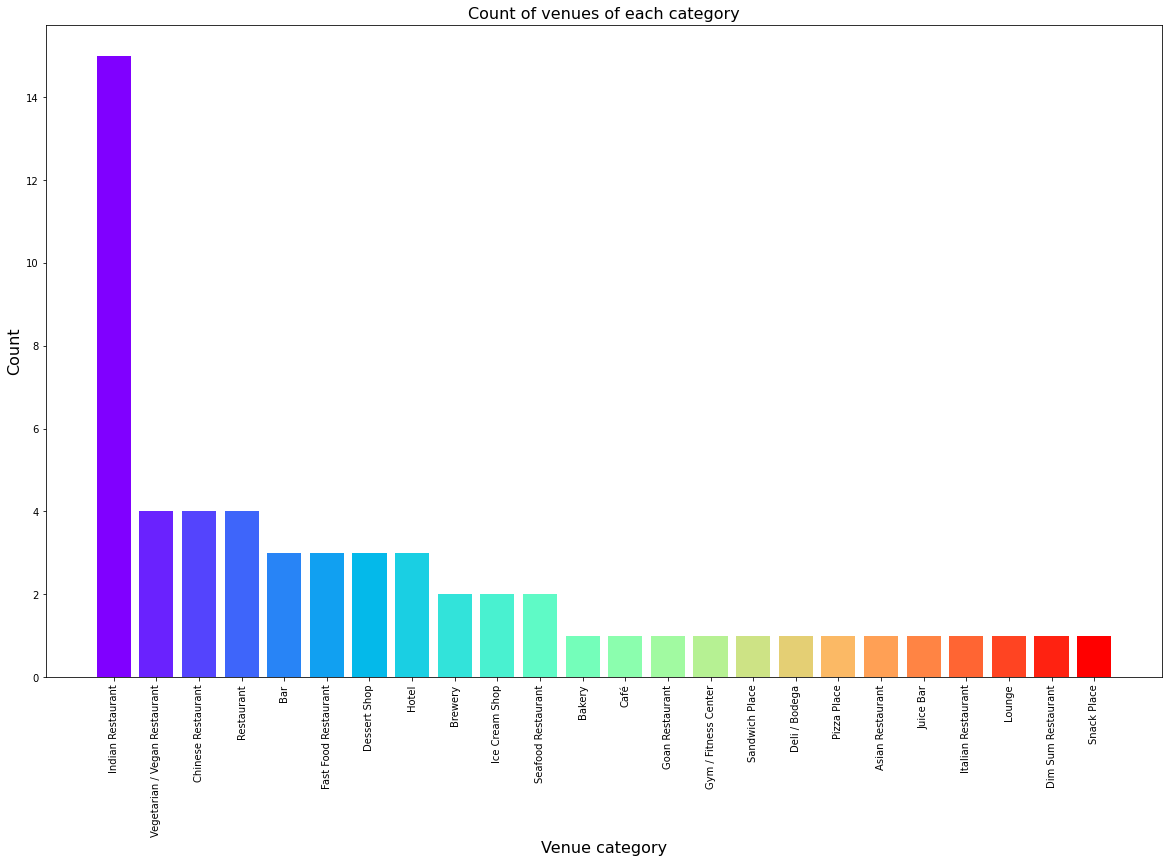

In [45]:
venue_distribution = selected_venues['Category'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)
plt.savefig('Count of venues of each category.jpg')

As we can see, the majority of the venues are **Indian Restaurant**, **Chinese Restaurant** and **Vegetarian Restauarant**. So, if as a tourist, you're looking for Indian and Chinese restaurants, you're in luck.

### Rating

Rating of a venue is an important factor on which a visitor decides whether it is worth it to visit the place or not. To cater to this, we will first see what is the average rating for all the venues in the city. Next, we will plot the venues on the map and color code them.

We'll first identify the various rating values and plot them as a bar plot with their counts to see the most common rating.

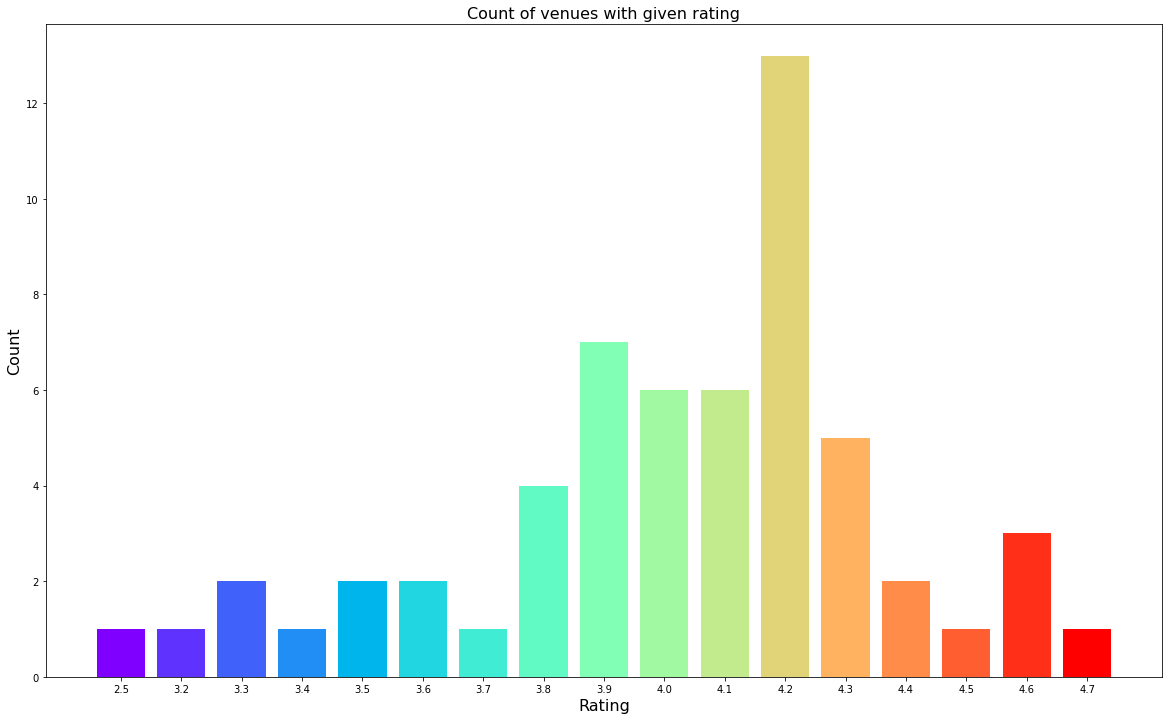

In [46]:
selected_venues['Rating'].astype(float)
rating = selected_venues['Rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)
plt.savefig('Count of venues with given rating.jpg')

From the plot above, it is clear that **majority venues** have their **rating close to 4**.

Let's create bins for various ratings and plot them in different colors on the map. The ratings will be divided between 4 bins:
* 1 to 2
* 2 to 3
* 3 to 4
* 4 to 5

In [47]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
selected_venues['Rating_bin'] = pd.cut(selected_venues['Rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

Now, we will plot the venues on the map.

In [48]:
color_map = {'Low': 'green', 'Okay': 'orange', 'Good': 'red', 'Very good': 'black'}

mumbai_map = folium.Map(location = [latitude, longitude], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['Venue'], 
                                                          selected_venues['Address'], 
                                                          selected_venues['Latitude'], 
                                                          selected_venues['Longitude'], 
                                                          selected_venues['Rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(mumbai_map)  

mumbai_map

The map has the location of all the venues. It appears that many venues are located near about **Bandra Kurla Complex**, **Ghatkopar East** and **Airport Area** with rating above 4. If someone wants to explore new venues, they should definitely check out these areas.

### Price

We will now take a look the venues based on the price values. We have two price features for our venues, one is `Avg. Price` which defines the average cost for one person and the other is `Price Range` which determines the price range as defined by Zomato.

We will first explore the `Avg. Price` using a scatter plot between the price and the count of venues with that average price. We'll size the points based on the price to highlight their price.

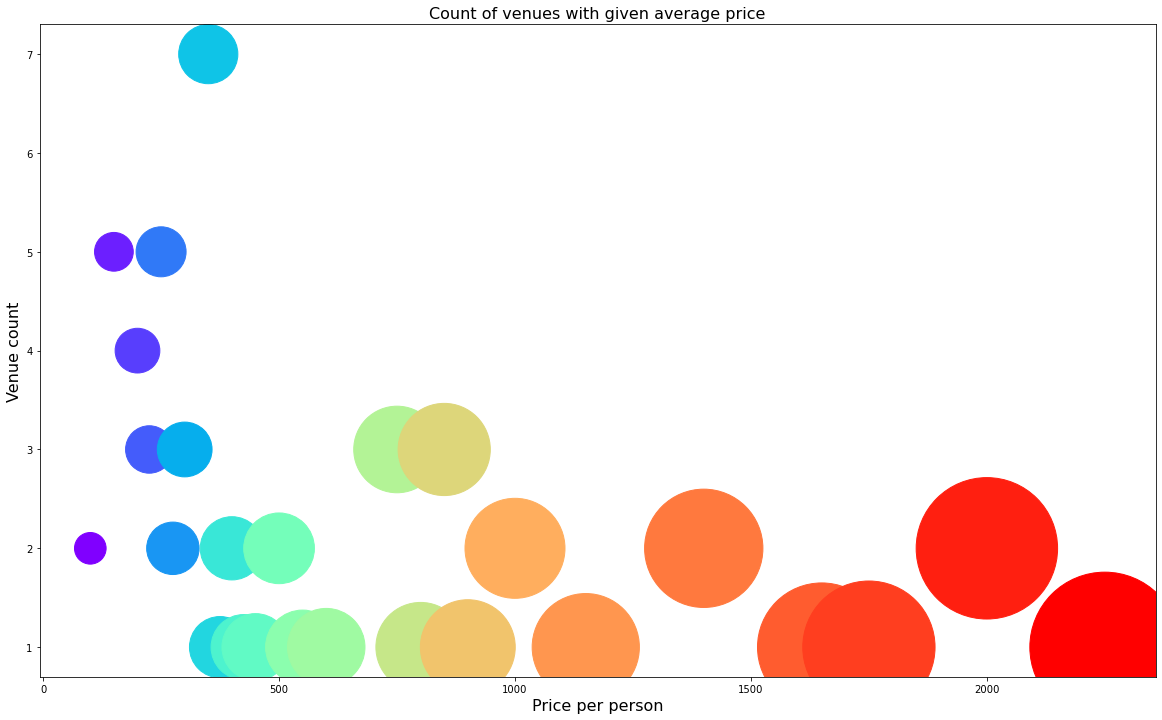

In [49]:
average_prices = selected_venues['Avg. Price'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)
plt.savefig('Count of venues with given average price.jpg')

From the plot above we can see that a large number of venues have an average price between Rs. 500 and Rs. 1000.

### Clustering

We will now cluster all these venues based on their price range, location and more to identify similar venues and the relationship amongst them. 
Now, to determine the optimal number of clusters, we will use the **Elbow Method**. A short description of **Elbow method** is given below -

`In the Elbow method, we are actually varying the number of clusters (K) from 1 – 10. For each value of K, we are calculating WCSS (Within-Cluster Sum of Square). WCSS is the sum of squared distance between each point and the centroid in a cluster. When we plot the WCSS with the K value, the plot looks like an Elbow.`

`As the number of clusters increases, the WCSS value will start to decrease. WCSS value is largest when K = 1. When we analyze the graph we can see that the graph will rapidly change at a point and thus creating an elbow shape. From this point, the graph starts to move almost parallel to the X-axis. The K value corresponding to this point is the optimal K value or an optimal number of clusters.`

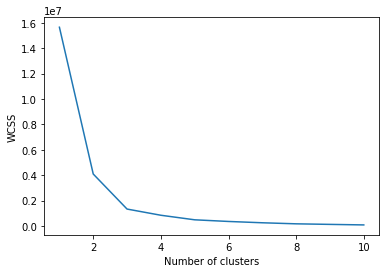

In [50]:
wcss = []
clustering = selected_venues.drop(['Venue', 'Category', 'Address', 'Rating_bin'], 1)

for k in range(1, 11):
    kMeans = KMeans(n_clusters = k, random_state = 0).fit(clustering)
    wcss.append(kMeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()

Thus, it is evident from the above graph that the **Elbow Point** is at K=3. Hence, the optimal number of clusters is **3**.

In [51]:
NO_OF_CLUSTERS = 3

clustering = selected_venues.drop(['Venue', 'Category', 'Address', 'Rating_bin'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues.head(5)

,cluster_labels,Venue,Category,Rating,Avg. Price,Price Range,Latitude,Longitude,Address,Rating_bin
0,0,Hitchki,Bar,4.2,850.0,3.0,19.0696,72.8699,"002, First International Financial Centre, G B...",Very good
1,1,Jyran - Sofitel,Hotel,4.5,1650.0,4.0,19.0676,72.8692,"Sofitel Hotel, C 57, Bandra Kurla Complex, Mumbai",Very good
2,2,Goodness To Go By Smoke House Deli,Deli / Bodega,3.9,400.0,2.0,19.0689,72.8696,"3A, Ground Floor, First International Financia...",Good
3,1,O22 - Trident,Hotel,4.2,2000.0,4.0,19.0671,72.8675,"Trident Hotel, C 56, G Block, Bandra Kurla Com...",Very good
4,1,Masala Library,Indian Restaurant,4.7,1750.0,4.0,19.0689,72.8697,"Ground Floor, 1st International Financial Cent...",Very good


**Now we will visualize the 3 restaurant clusters with the help of a Folium map of Mumbai.**

In [52]:
mumbai_map = folium.Map(location = [latitude, longitude], zoom_start = 13)
color_map = { 0: 'blue', 1: 'red', 2: 'yellow'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['Venue'], 
                                                        selected_venues['Address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['Latitude'], 
                                                        selected_venues['Longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 6,
        popup = label,
        color = 'black',
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(mumbai_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[3]
    longitude = cluster[4]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    
    folium.CircleMarker(
        [latitude, longitude],
        radius = 12,
        popup = label,
        color = 'black',
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(mumbai_map)

mumbai_map

In [53]:
# Count of venues within each cluster
selected_venues.groupby('cluster_labels')[['Venue']].count()

,Venue
cluster_labels,
0,12
1,7
2,39


**From the map, we can see:**
1. The 1st cluster (**blue**) is very sparsely spread and has very limited (**12**) venues.
2. The 2nd cluster (**red**) is also sparsely spread like 1st cluster, having only **7** venues.
3. The 3rd cluster (**yellow**) is spread across the whole city and includes the majority (**39**) venues.

**We will now check the venues within each of these 3 clusters.**

### Cluster 0

In [54]:
result0 = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result0.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,Venue,Category,Rating,Avg. Price,Price Range,Latitude,Longitude,Address,Rating_bin
0,0,Hitchki,Bar,4.2,850.0,3.0,19.0696,72.8699,"002, First International Financial Centre, G B...",Very good
1,0,Ivy Restaurant And Banquets,Restaurant,4.4,800.0,3.0,19.0696,72.9004,"Near Shopper's Stop, Amar Mahal, M G Road, Che...",Very good
2,0,O Pedro,Goan Restaurant,4.6,900.0,3.0,19.0591,72.8648,"Unit 2, Plot C 68, Jet Airways - Godrej, Bandr...",Very good
3,0,Toast & Tonic,Bar,4.2,850.0,3.0,19.0595,72.8647,"Unit 1, Ground Floor, Jet Airways, Godrej Buil...",Very good
4,0,Wild Orchids,Asian Restaurant,4.0,1000.0,4.0,19.0618,72.9017,"Hotel Royal Orchid, NG Acharya Marg, Chembur, ...",Good
5,0,British Brewing Company,Brewery,4.2,1000.0,4.0,19.1077,72.8832,"Ground Floor, Times Square Tech Park, Andheri ...",Very good
6,0,Gateway Taproom,Brewery,4.6,1150.0,4.0,19.0592,72.8650,"Plot C - 68, Unit 3, Godrej BKC, G Block, Band...",Very good
7,0,BouganVilla,Restaurant,4.1,750.0,3.0,19.0854,72.9089,"1, Ground Floor, Neelyog Square, Ghatkopar Eas...",Very good
8,0,Le Café,Café,4.2,750.0,3.0,19.0617,72.8997,"Opposite B.M.C Office, 1st Road, Chembur, Mumbai",Very good
9,0,Orchids,Lounge,4.3,750.0,3.0,19.0618,72.9017,"Hotel Royal Orchid, NG Acharya Marg, Chembur, ...",Very good


### Cluster 1

In [55]:
result1 = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result1.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,Venue,Category,Rating,Avg. Price,Price Range,Latitude,Longitude,Address,Rating_bin
0,1,Jyran - Sofitel,Hotel,4.5,1650.0,4.0,19.0676,72.8692,"Sofitel Hotel, C 57, Bandra Kurla Complex, Mumbai",Very good
1,1,O22 - Trident,Hotel,4.2,2000.0,4.0,19.0671,72.8675,"Trident Hotel, C 56, G Block, Bandra Kurla Com...",Very good
2,1,Masala Library,Indian Restaurant,4.7,1750.0,4.0,19.0689,72.8697,"Ground Floor, 1st International Financial Cent...",Very good
3,1,Yauatcha,Dim Sum Restaurant,4.6,1400.0,4.0,19.0610,72.8625,"Raheja Tower, Bandra Kurla Complex, Mumbai",Very good
4,1,CinCin,Italian Restaurant,4.1,1400.0,4.0,19.0611,72.8630,"Ground Floor, Raheja Towers, Bandra East, Mumbai",Very good
5,1,Glasshouse - Hyatt Regency Mumbai,Hotel,4.2,2250.0,4.0,19.1032,72.8715,"Airport Sahar Road, Andheri East, Chakala, Mumbai",Very good
6,1,JW Café - JW Marriott Mumbai Sahar,Restaurant,4.4,2000.0,4.0,19.1032,72.8772,"Chhatrapati Shivaji International Airport, IA ...",Very good


### Cluster 2

In [56]:
result2 = selected_venues[selected_venues['cluster_labels'] == 2]
print("Cluster 2")
result2.head(10).reset_index(drop = True)

Cluster 2


,cluster_labels,Venue,Category,Rating,Avg. Price,Price Range,Latitude,Longitude,Address,Rating_bin
0,2,Goodness To Go By Smoke House Deli,Deli / Bodega,3.9,400.0,2.0,19.0689,72.8696,"3A, Ground Floor, First International Financia...",Good
1,2,Natural Ice Cream,Ice Cream Shop,4.2,150.0,1.0,19.0776,72.8628,"3, Gokul Harmony, Kalina Market, Sunder Nagar,...",Very good
2,2,Naaz Hotel,Indian Restaurant,4.2,350.0,2.0,19.0848,72.8891,"Opposite Phoenix Market City, Kantharia Mahal,...",Very good
3,2,Theobroma,Dessert Shop,4.3,250.0,2.0,19.0636,72.8618,"The Capital, Ground Floor, Bandra Kurla Comple...",Very good
4,2,Delhi Zaika,Indian Restaurant,3.8,350.0,2.0,19.0772,72.8783,"5/6, LBS Marg, Near Kamran Kalpana Theater, Ku...",Good
5,2,Hotel Darshan,Chinese Restaurant,3.5,150.0,1.0,19.0826,72.8852,"Kurla West, Opposite Kohinoor City Gate, Kurla...",Good
6,2,The Bombay Chow,Snack Place,2.5,250.0,2.0,19.0570,72.8981,"Shop 3/204, Sukh Sagar Building, Central Avenu...",Okay
7,2,Purshottam Kandoi Haribhai Damodar Mithaiwala,Dessert Shop,4.3,100.0,1.0,19.0824,72.9047,"Opposite Titian Showroom, Gayatri Dham, MG Roa...",Very good
8,2,Chocday,Dessert Shop,3.9,250.0,2.0,19.0750,72.9050,"Unit 15, Vikrant Building, Vikrant Circle, Gha...",Good
9,2,5 Spice,Chinese Restaurant,4.0,550.0,3.0,19.1062,72.8848,"Ground Floor, Shivai Industrial Estate, Opposi...",Good


**Now we will check the average price range and rating for the restaurants within each cluster**

In [57]:
print("Cluster 0 restaurants have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result0['Price Range'].mean(), result0['Rating'].astype(float).mean()))
print("Cluster 1 restaurants have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result1['Price Range'].mean(), result1['Rating'].astype(float).mean()))
print("Cluster 2 restaurants have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result2['Price Range'].mean(), result2['Rating'].astype(float).mean()))

Cluster 0 restaurants have mean price range of 3.25 and rating spread around 4.24
Cluster 1 restaurants have mean price range of 4.00 and rating spread around 4.39
Cluster 2 restaurants have mean price range of 1.72 and rating spread around 3.87


Thus, the restaurant venues in Mumbai can be clustered into 3 types -  
**1. Cluster 0** - Medium Price Range, Very Good rating  
**2. Cluster 1** - High Price Range, Very Good rating  
**3. Cluster 2** - Low Price Range, Good rating  

### Results and Discussion <a name="results"></a>

Based on our analysis above, we can draw a number of conclusions that will be useful to aid any visitor visiting the city of Mumbai, India.

After collecting data from the **Foursquare** and **Zomato** APIs, we got a list of 86 different venues. However, not all venues from the two APIs were identical. Hence, we had to inspect their latitude and longitude values as well as names to combine them and remove all the outliers. This resulted in a total venue count of 54.

**1.** We identified that from the total set of venues, majority of them were **Indian Restaurant**, **Chinese Restaurant** and **Vegetarian Restaurant**. A visitor who loves Indian/Chinese Restaurants would love to travel to Mumbai.  

**2.** While the complete range of ratings range from 1 to 5, the **majority venues have ratings close to 4**. This means that most restaurants provide **good quality food** which is liked by the people of the city, thus indicating the high rating. When we plot these venues on the map, we discover that there are clusters of venues around **Bandra Kurla Complex**, **Ghatkopar East** and **Airport Area**. These clusters also have very **high ratings (more than 3)**.  

**3.** When we take a look at the price values of each venue, we explore that **many venues** have prices which are in the **range of Rs 500 to Rs 1000 for one person**. However, the variation in prices is very large, given the complete range starts from Rs. 100 and goes uptil Rs. 2250. On plotting the venues based on their price range on the map, we discovered that **venues located near Ghatkopar East and Chembur West are relatively priced lower than venues in Airport Area and Bandra Kurla Complex**.  

**4.** Finally, through clusters we identified that there are **many venues** which are **relatively lower priced but have an average rating of 3.87**. There are also **few venues** which are **high priced and have average rating of 4.39**. At last, few of the restaurants are **medium priced and have average rating of 4.24**.

   * If you're looking for cheap places with relatively high rating, you should check out venues in **Ghatkopar East**, **Santa      Cruz** and **Chembur West**.
   * If you're looking for the best places, with the highest rating but might also carry a high price tag, you should visit          venues in **Airport Area** and **Bandra Kurla Complex**.
   * If you're looking for medium priced places with high rating, you should visit venues in **Chembur West** and                  **Bandra Kurla Complex**.

A company can use this information to build up an online website/mobile application, to provide users with up to date information about various venues in the city based on the search criteria (name, rating and price).

### Conclusion <a name="conclusion"></a>

The purpose of this project was to explore the places that a person visiting Mumbai could visit. The venues have been identified using Foursquare and Zomato API and have been plotted on the map. The map reveals that there are four major areas a person can visit: **Ghatkopar East, Chembur West, Airport Area** and **Bandra Kurla Complex**. Based on the visitor's venue rating and price requirements, he/she can choose amongst the three places.